# Exemple emcee
## Génération de fausses données

Nous allons d'abord générer des données pour les utiliser dans l'exemple.
Les données seront générées avec une fonction sinus. On ajoute ensuite un bruit gaussien aux valeurs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# np.random.seed(123)  # Pour toujours avoir les mêmes valeurs random

# Définition des vrais paramètres
amp_true = 1.6
per_true = 0.7
phi_true = 1.1
off_true = 0.2
sigma_true = 0.5
truths =  [
    amp_true,
    per_true,
    phi_true,
    off_true,
    sigma_true
]

npts = 50
t = np.sort(2 * per_true * np.random.rand(npts))
y_true = amp_true * np.sin(2*np.pi * t / per_true + phi_true) + off_true
yerr = amp_true * 0.01 + 0.09 * amp_true * np.random.rand(npts)
y = y_true + yerr * np.random.randn(npts)

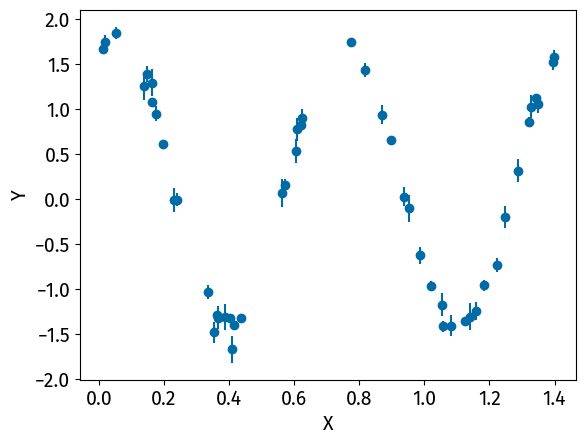

In [2]:
plt.errorbar(t, y, yerr=yerr, fmt="o")
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

## Définition du problème

Une fois que les données sont connues, il est temps de formuler le problème pour l'analyse MCMC.
On définit d'abord notre modèle qui permet de générer les valeurs de Y pour une série de valeurs X (ou `t` dans le code). Les paramètres sont dénotés par `theta`.
La fonction de vraisemblance est une probablité gaussienne et les priors sont tous uniforme.
La distribution « posterior » n'est qu'une multiplication du prior par la vraisemblance: l'évidence n'est pas utilisée avec `emcee`.
Remarquez que toutes les distributions sont sous forme logarithmique. Ceci aide à la stabilité numérique et l'exploration efficace de l'espace-paramètres.

In [3]:
def model(t, theta):
    amp, per, phi, off = theta
    ymod = amp * np.sin(2 * np.pi * t / per + phi) + off
    return ymod


def log_likelihood(theta, t, y, yerr):
    modvals = model(t, theta)

    sigma2 = yerr ** 2
    norm_const = -0.5 * np.sum(np.log(2 * np.pi * sigma2))
    chisq = np.sum((y - modvals) ** 2 / sigma2)

    return -0.5 * chisq + norm_const


def uniform_prior(pval, minval, maxval):
    if minval <= pval <= maxval:
        return - np.log(maxval - minval)
    return - np.inf


def log_prior(theta):
    amp, per, phi, off = theta
    prior = 0.0
    prior += uniform_prior(amp, 0.0, 10.0)
    prior += uniform_prior(per, 0.0, 10.0)
    prior += uniform_prior(phi, -np.pi, np.pi)
    prior += uniform_prior(off, -10.0, 10.0)
    return prior


def log_posterior(theta, t, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, y, yerr)

## Test du modèle

On peut maintenant tester le modèle pour explorer à l'oeil quelques valeurs de paramètres et s'assurer que le modèle correspond environ aux données.

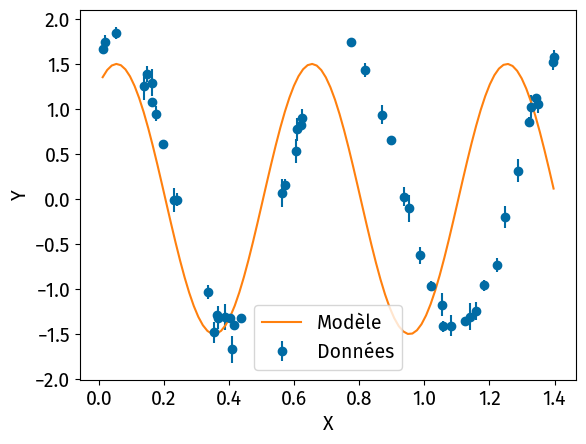

In [4]:
pguess = np.array([1.5, 0.6, 1.0, 0.0])
tmod = np.linspace(t.min(), t.max(), num=100)
plt.errorbar(t, y, yerr=yerr, fmt="o", label="Données")
plt.plot(tmod, model(tmod, pguess), label="Modèle")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

## MCMC avec emcee

Il est maintenant temps d'estimer les valeurs de chaque paramètre avec `emcee`. 

In [5]:
import emcee

In [6]:
nwalkers = 100
ndims = pguess.size
sampler = emcee.EnsembleSampler(nwalkers, ndims, log_posterior, args=(t, y, yerr))

In [7]:
nsteps = 5000
pos = pguess + 1e-4 * np.random.randn(nwalkers, ndims)
sampler.run_mcmc(pos, nsteps, progress=True);

100%|██████████████████████████████████████| 5000/5000 [00:13<00:00, 369.50it/s]


Un premier diagnostic souvent utile consiste à regarder l'évolution des chaines (tous les « walkers » sont affichés pour chaque paramètre). Ce graphique permet généralement d'identifier le « burn-in » requis.

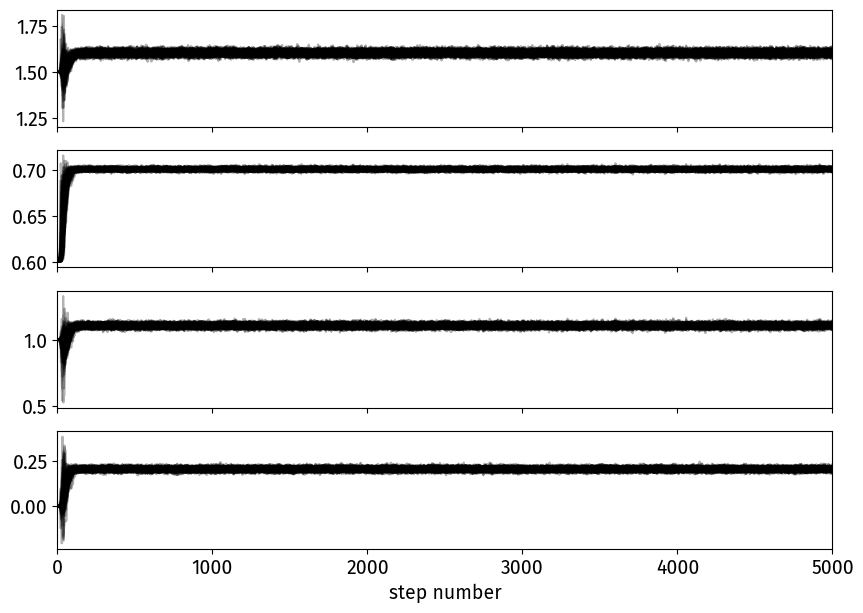

In [8]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain(discard=0)
# labels = ["m", "b", "log(f)"]
for i in range(ndims):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    # ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")
plt.show()

En regardant le graphique ci-dessus, il semble qu'après 200 pas le « burn-in » soit terminé. Comme nous avons beaucoup d'échantillons, couper les 1000 premiers ne devrait pas poser problème et permet de s'assurer que nous utilisons uniquement des échantillons pour lesquels le burn-in est terminé.

Un autre type de graphique utile est le « corner plot ». Ce graphique affiche un histogramme pour chaque paramètre (distribution marginanlisée), ainsi que la distribution 2D pour chaque paire de paramètre. On peut ainsi voir les (anti-)corrélations entre certains paramètres.

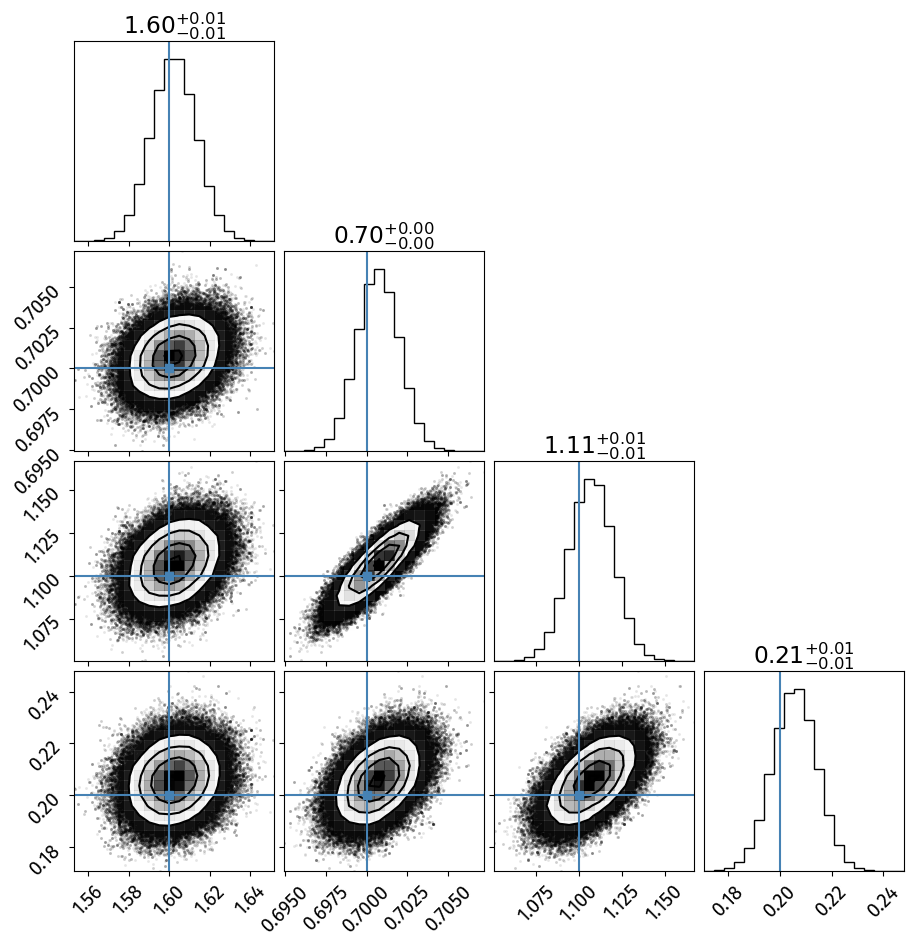

In [9]:
import corner

flat_samples = sampler.get_chain(discard=1000, flat=True)

corner.corner(flat_samples, show_titles=True, truths=truths)
plt.show()